<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Started

First, let's import the tools we'll be using. We've seen most of these before, with one new one: `medigan`.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import medigan
import torch
import torch.optim as optim
import torchvision
from torchvision.io import read_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

Since we'll be working with large models in this notebook, let's make sure we're using GPUs.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Medigan Models

In the previous lesson we created our own GAN. But we can get pre-trained ones as well. One called [medigan](https://github.com/RichardObi/medigan) is exactly what we need — it generates medical images.

It's actually a whole collection of GANs. `medigan.Generators` gives us access to the GANs in the package. Here we can see the available ones, which you can also see [here](https://github.com/RichardObi/medigan?tab=readme-ov-file#available-models).

In [3]:
generators = medigan.Generators()

generators.list_models()

['00001_DCGAN_MMG_CALC_ROI',
 '00002_DCGAN_MMG_MASS_ROI',
 '00003_CYCLEGAN_MMG_DENSITY_FULL',
 '00004_PIX2PIX_MMG_MASSES_W_MASKS',
 '00005_DCGAN_MMG_MASS_ROI',
 '00006_WGANGP_MMG_MASS_ROI',
 '00007_INPAINT_BRAIN_MRI',
 '00008_C-DCGAN_MMG_MASSES',
 '00009_PGGAN_POLYP_PATCHES_W_MASKS',
 '00010_FASTGAN_POLYP_PATCHES_W_MASKS',
 '00011_SINGAN_POLYP_PATCHES_W_MASKS',
 '00012_C-DCGAN_MMG_MASSES',
 '00013_CYCLEGAN_MMG_DENSITY_OPTIMAM_MLO',
 '00014_CYCLEGAN_MMG_DENSITY_OPTIMAM_CC',
 '00015_CYCLEGAN_MMG_DENSITY_CSAW_MLO',
 '00016_CYCLEGAN_MMG_DENSITY_CSAW_CC',
 '00017_DCGAN_XRAY_LUNG_NODULES',
 '00018_WGANGP_XRAY_LUNG_NODULES',
 '00019_PGGAN_CHEST_XRAY',
 '00020_PGGAN_CHEST_XRAY',
 '00021_CYCLEGAN_BRAIN_MRI_T1_T2',
 '00022_WGAN_CARDIAC_AGING',
 '00023_PIX2PIXHD_BREAST_DCEMRI']

Each one has an id number (the first number in the name) and a somewhat descriptive name. But we'll want more information to decide which one we want. We can get the configuration for the first one, this tells us a lot about what the model does. The `model_id` can be either the id number or the whole name.

In [4]:
model_00001_config = generators.get_config_by_id(model_id=1)
model_00001_config

{'execution': {'package_name': '00001_DCGAN_MMG_CALC_ROI',
  'package_link': 'https://zenodo.org/record/7031735/files/00001_DCGAN_MMG_CALC_ROI.zip?download=1',
  'model_name': 'DCGAN',
  'extension': '.pt',
  'image_size': [128, 128],
  'dependencies': ['numpy', 'Path', 'torch', 'opencv-contrib-python-headless'],
  'generate_method': {'name': 'generate',
   'args': {'base': ['model_file',
     'num_samples',
     'output_path',
     'save_images'],
    'custom': {'image_size': 128}},
   'input_latent_vector_size': 100}},
 'selection': {'performance': {'SSIM': None,
   'MSE': None,
   'NSME': None,
   'PSNR': None,
   'IS': None,
   'turing_test': None,
   'FID_no_images': 1000,
   'FID': 67.6,
   'FID_ratio': 0.497,
   'FID_RADIMAGENET': 1.27,
   'FID_RADIMAGENET_ratio': 0.197,
   'CLF_delta': None,
   'SEG_delta': None,
   'CLF': {'trained_on_fake': {},
    'trained_on_real_and_fake': {},
    'trained_on_real': {}},
   'SEG': {'trained_on_fake': {},
    'trained_on_real_and_fake': {},

This is a lot of information! Let's pick out just the most important pieces.

**Task 5.3.1:** Make a new dictionary called `model_00001_info` that has just the `organ`, `modality`, `tags` keys from within the `selection` key in `model_00001_config`.

In [5]:
model_00001_info = {
    k: model_00001_config["selection"][k] for k in ["organ", "modality", "tags"]
}
model_00001_info

{'organ': ['breast', 'breasts', 'chest'],
 'modality': ['MMG',
  'Mammography',
  'Mammogram',
  'full-field digital',
  'full-field digital MMG',
  'full-field MMG',
  'full-field Mammography',
  'digital Mammography',
  'digital MMG',
  'x-ray mammography'],
 'tags': ['Mammogram',
  'Mammography',
  'Digital Mammography',
  'Full field Mammography',
  'Full-field Mammography',
  '128x128',
  '128 x 128',
  'MammoGANs',
  'Microcalcification',
  'Microcalcifications']}

**Task 5.3.2:** Extract the `title` and `comment` keys from the `description` key in `model_00001_config` and add it to the `model_00001_info` dictionary.

In [6]:

model_00001_info = {
    k: model_00001_config["description"][k] for k in ["title", "comment"]
}

model_00001_info

{'title': 'DCGAN Model for Mammogram Calcification Region of Interest Generation (Trained on INbreast)',
 'comment': 'A deep convolutional generative adversarial network (DCGAN) that generates regions of interest (ROI) of mammograms containing benign and/or malignant calcifications. Pixel dimensions are 128x128. The DCGAN was trained on ROIs from the INbreast dataset (Moreira et al, 2012). The uploaded ZIP file contains the files dcgan.pt (model weights), __init__.py (image generation method and utils), a README.md, and the GAN model architecture (in pytorch) below the /src folder. Kernel size=6 used in DCGAN discriminator.'}

There's a lot of good information here. This model generates images of mammograms, of size $128$ x $128$ pixels. Let's look at another one.

**Task 5.3.3:** Get the configuration for model $7$, and extract `organ`, `modality`, `tags` keys from within the `selection` key and the `title` and `comment` keys from the `description` key. Store that information in `model_00007_info`.

In [7]:
model_00007_config = generators.get_config_by_id(model_id=7)


model_00007_info = {
    k: model_00001_config["selection"][k] for k in ["organ", "modality", "tags"]
}

model_00007_info.update({
    k: model_00007_config["description"][k] for k in ["title", "comment"]
})

model_00007_info

{'organ': ['breast', 'breasts', 'chest'],
 'modality': ['MMG',
  'Mammography',
  'Mammogram',
  'full-field digital',
  'full-field digital MMG',
  'full-field MMG',
  'full-field Mammography',
  'digital Mammography',
  'digital MMG',
  'x-ray mammography'],
 'tags': ['Mammogram',
  'Mammography',
  'Digital Mammography',
  'Full field Mammography',
  'Full-field Mammography',
  '128x128',
  '128 x 128',
  'MammoGANs',
  'Microcalcification',
  'Microcalcifications'],
 'title': 'Tumor Inpainting Model for Generation of Flair, T1, T1c, T2 Brain MRI Images (Trained on BRATS)',
 'comment': 'A Generative adversarial network (GAN) for Inpainting tumors (based on concentric circle-based tumor grade masks) into multi-modal MRI images (Flair, T1, T1c, T2) with dimensions 256x256. Model was trained on BRATS MRI Dataset (Menze et al). For more information, see publication (https://doi.org/10.1002/mp.14701). Model comes with example input image folders. Apart from that, the uploaded ZIP file co

This one is creating images of brain MRIs with tumors.

While this is very valuable information, we aren't going to want to look through this for every model to find the kind of images we want. Medigan provides us with the ability to search through the configurations. We have to say which key we want to search over - usually `organ`, `modality`, or `tags`, but you can search the others too. Let's see which models look at the brain, in the `organ` key. We'll set it to not be case-sensitive, so we don't have to worry about capitalization.

In [8]:
key = "organ"
value = "brain"

found_models = generators.get_models_by_key_value_pair(
    key1=key, value1=value, is_case_sensitive=False
)
print(found_models)

[{'model_id': '00007_INPAINT_BRAIN_MRI', 'organ': 'brain'}, {'model_id': '00021_CYCLEGAN_BRAIN_MRI_T1_T2', 'organ': 'brain'}]


The search has returned a list of dictionaries, with each dictionary one model that matched. We got only two models back, at least as of the time this notebook was written.

Let's see which models are about mammograms.

**Task 5.3.4:** Search for models that have `mammogram` in their `tags`. Make sure the search isn't case sensitive.

In [11]:
key = "tags"
value = "mammogram"

found_models = generators.get_models_by_key_value_pair(
    key1=key, value1=value, is_case_sensitive=False
)

print(found_models)
print()
print(f"Found {len(found_models)} models")

[{'model_id': '00001_DCGAN_MMG_CALC_ROI', 'tags': 'mammogram'}, {'model_id': '00002_DCGAN_MMG_MASS_ROI', 'tags': 'mammogram'}, {'model_id': '00003_CYCLEGAN_MMG_DENSITY_FULL', 'tags': 'mammogram'}, {'model_id': '00004_PIX2PIX_MMG_MASSES_W_MASKS', 'tags': 'mammogram'}, {'model_id': '00005_DCGAN_MMG_MASS_ROI', 'tags': 'mammogram'}, {'model_id': '00006_WGANGP_MMG_MASS_ROI', 'tags': 'mammogram'}, {'model_id': '00008_C-DCGAN_MMG_MASSES', 'tags': 'mammogram'}, {'model_id': '00012_C-DCGAN_MMG_MASSES', 'tags': 'mammogram'}, {'model_id': '00013_CYCLEGAN_MMG_DENSITY_OPTIMAM_MLO', 'tags': 'mammogram'}, {'model_id': '00014_CYCLEGAN_MMG_DENSITY_OPTIMAM_CC', 'tags': 'mammogram'}, {'model_id': '00015_CYCLEGAN_MMG_DENSITY_CSAW_MLO', 'tags': 'mammogram'}, {'model_id': '00016_CYCLEGAN_MMG_DENSITY_CSAW_CC', 'tags': 'mammogram'}]

Found 12 models


We can then fetch a model's configuration to learn more about it. The `get_config_by_id` we used before understands the `model_id` we get from the search. We've already seen the first one, so let's look at the second one that the search found.

In [12]:
model_id = found_models[1]["model_id"]

model_config = generators.get_config_by_id(model_id=model_id)

print("Model's description:")
model_config["description"]

Model's description:


{'title': 'DCGAN Model for Mammogram Mass Region of Interest Generation (Trained on OPTIMAM)',
 'provided_date': None,
 'trained_date': None,
 'provided_after_epoch': None,
 'version': None,
 'publication': None,
 'doi': ['10.5281/zenodo.5188557', '10.1117/12.2543506', '10.1117/12.2560473'],
 'inputs': [],
 'comment': 'A deep convolutional generative adversarial network (DCGAN) that generates regions of interest (ROI) of mammograms containing benign and/or malignant masses. Pixel dimensions are 128x128. The DCGAN was trained on ROIs from the Optimam dataset (Halling-Brown et al, 2014). The uploaded ZIP file contains the files malign_mass_gen (model weights), and __init__.py (image generation method and pytorch GAN model architecture). Kernel size=6 used in DCGAN discriminator.'}

**Task 5.3.5:** Get the model configuration for the third model we got in our search.

In [13]:

model_id = found_models[2]["model_id"]

model_config = generators.get_config_by_id(model_id=model_id)

print("Model's description:")
model_config["description"]

Model's description:


{'title': 'CycleGAN Model for Low-to-High Brest Density Mammograms Translation (Trained on BCDR)',
 'provided_date': '12th Sep 2021',
 'trained_date': 'Sep 2021',
 'provided_after_epoch': 100,
 'version': '0.0.1',
 'publication': None,
 'doi': ['https://doi.org/10.48550/arXiv.2209.09809'],
 'inputs': ['input_path: default=models/00003_CYCLEGAN_MMG_DENSITY_FULL/images, help=the path to .png mammogram images that are translated from low to high breast density or vice versa',
  'image_size: default=[1332, 800], help=list with image height and width. Images are rescaled to these pixel dimensions.',
  'gpu_id: default=0, help=the gpu to run the model on.',
  'translate_all_images: default=False, help=flag to override num_samples in case the user wishes to translate all images in the specified input_path folder.'],
 'comment': 'A cycle generative adversarial network (CycleGAN) that generates mammograms with high breast density from an original mammogram e.g. with low-breast density. The Cycl

We're not limited to searching for a single value. We can search over multiple terms at once with `find_matching_models_by_values`, and give a list of values. We don't need to specify a key now, as it will look through all the keys. It returns any model that has matches for all of our values.

Let's narrow down our mammograms to ones that are also about calcification.

In [14]:
values_list = ["mammogram", "calcification"]
found_models = generators.find_matching_models_by_values(
    values=values_list,
    is_case_sensitive=False,
)
print(f"Found models: {found_models}")

Found models: [ModelMatchCandidate(model_id=00001_DCGAN_MMG_CALC_ROI, is_match=True, operator: AND, target_values=['mammogram', 'calcification'])]


Just one response this time. The result comes back a little different than before. Instead of a list of dictionaries, we get a list of `ModelMatchCandidate` objects. They have information about the match, but all we're concerned about is the `model_id`. Let's grab that for later.

In [15]:
model_id_mammogram = found_models[0].model_id

model_id_mammogram

'00001_DCGAN_MMG_CALC_ROI'

<div class="alert alert-info" role="alert">
We can also use this tool to get a <i>broader</i> search. By default it looks for things that match all of our values. It checks if a model matches each value, then performs a logical <tt>AND</tt> operation. This will only return a model if all of the matches came back with <tt>True</tt>. We could instead set it to use a logical <tt>OR</tt> operation by giving it an additional argument <tt>target_values_operator="OR"</tt>. Then it would return a model if <i>any</i> of the values came back with <tt>True</tt>. This would let us find, for example, everything with the terms chest, lung, and thorax if we were worried models were labeled with different terms.
</div>

Let's find a model that gives lung X-rays. Let's look for high resolution images, so we have something nice to display on the screen when we use it to generate images.

**Task 5.3.6:** Search for a model that is marked with `lung`, `xray` and `1024` (for $1024$ by $1024$ images, which will be easier for us as humans to understand). There should be only one. Save the model's id to `lung_xray_id`.

In [16]:

values_list = ["lung", "xray", 1024]
found_models = generators.find_matching_models_by_values(
    values=values_list,
    is_case_sensitive=False,
)

lung_xray_id = found_models[0].model_id

print(f"Lung x-ray model ID: {lung_xray_id}")

Lung x-ray model ID: 00019_PGGAN_CHEST_XRAY


### Generating Images

Now that we've picked a model, we can ask it to generate images for us. We do this with `generate`. We tell it which model and how many images (samples) to generate. It will go and download the model, set it up, then run it to create what we've asked for. By default, it creates the images as files and saves them to `output_path`, but we can also get them as a `numpy` array.

Let's erase anything we may have generated in the past.

In [17]:
! rm -rf output

We'll need to tell it where to save the outputs. It defaults to a directory with the model name and a timestamp, but we'll set it to something more memorable.

**Task 5.3.7:** Create a path to the directory `output/sample_lung`. Use `Pathlib`.

In [18]:
output_dir = Path("output")
sample_dir = output_dir / "sample_lung"

print(sample_dir)

output/sample_lung


We'll generate $8$ lung x-ray images by setting `num_samples=8`. It should take a few seconds to create the images.

In [19]:
generators.generate(
    model_id=lung_xray_id,
    num_samples=8,
    output_path=sample_dir,
)

100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


And we can run this function to view a selection of the images in a directory.

In [20]:
def view_images(directory, num_images=4, glob_rule="*"):
    """Displays a sample of images in the given directory
    They will display in rows of 4 images
    - directory: which directory to look for images
    - num_images: how many images to display (default 4, for one row)
    - glob_rule: argument to glob to filter images (default "*" selects all)"""

    image_list = list(directory.glob(glob_rule))
    num_samples = min(num_images, len(image_list))
    images = [read_image(str(f)) for f in sorted(image_list)[:num_samples]]
    grid = make_grid(images, nrow=4, pad_value=255.0)
    return torchvision.transforms.ToPILImage()(grid)

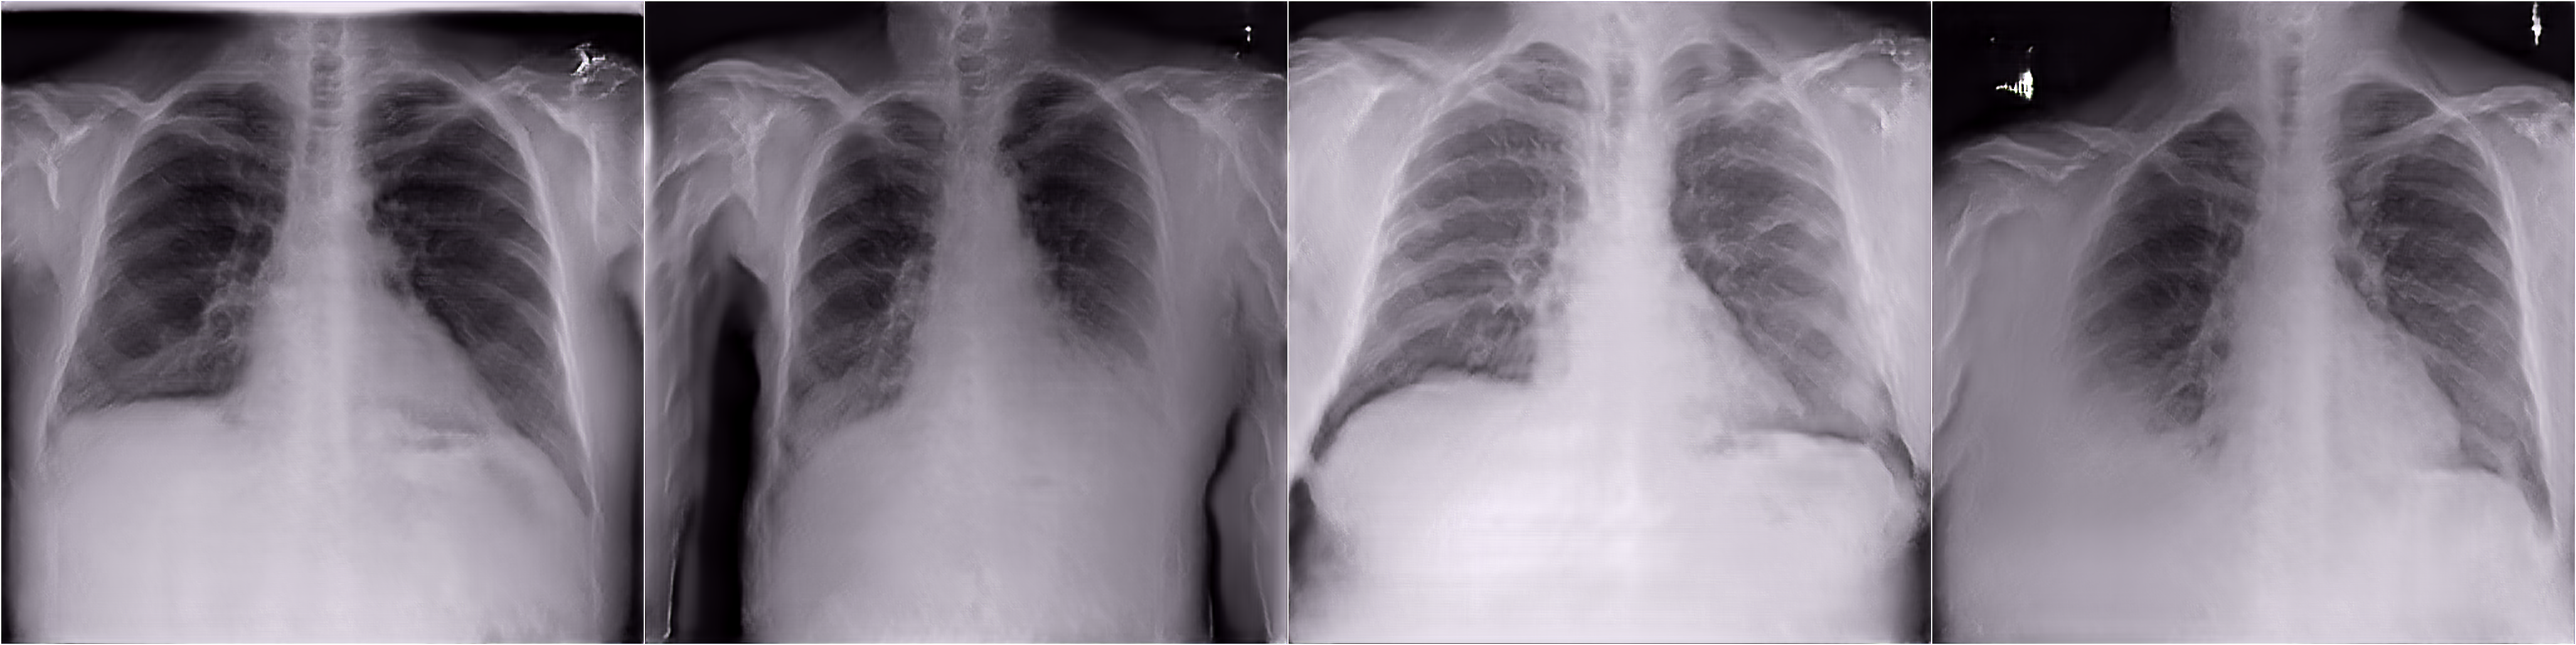

In [21]:
view_images(sample_dir)

They look like chest x-rays, if a little strange. This is not unusual for a GAN, the images have basically the correct overall "shape" but the details aren't always right.

For the rest of the lesson, we'll be working with model `10`, named `00010_FASTGAN_POLYP_PATCHES_W_MASKS`. Let's see what it produces.

**Task 5.3.8:** Generate $8$ images from model `10` and store them in the directory `output/polyp_samples`. Save the directory path in `polyp_dir`, we'll use it later. This may take a minute or so to run.

In [22]:
model_id = 10
polyp_dir = output_dir / "polyp_samples"

generators.generate(model_id, num_samples=8, output_path=polyp_dir)

print(
    f"Created {len(list(polyp_dir.glob('*')))} images (should be twice the number asked for)"
)

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

Created 16 images (should be twice the number asked for)


In [23]:
output_dir

PosixPath('output')

This actually generates two kinds of images: the medical image, and a "mask". This is why we have twice the number we asked for, as we get one image and its mask for each sample we ask for. The images are endoscope images of polyps, or growths. Here are a few.

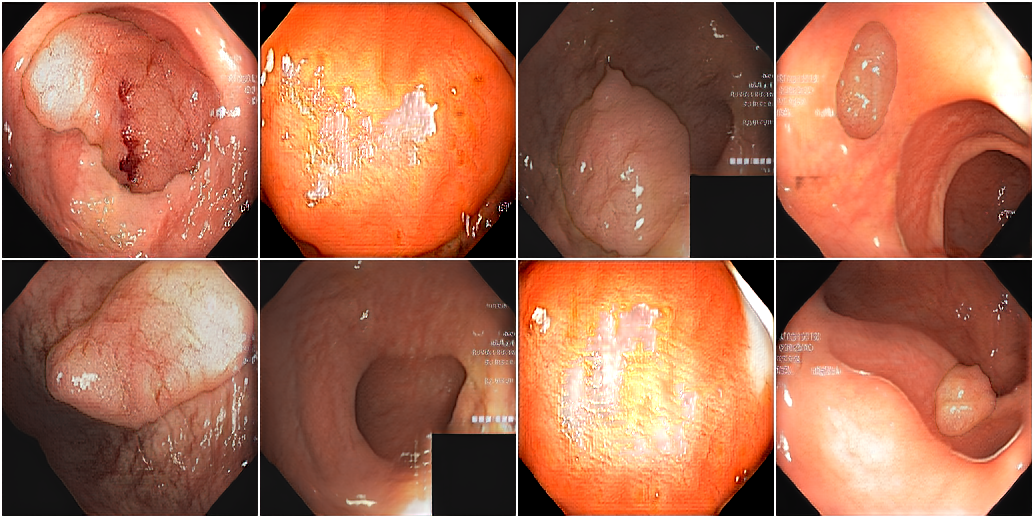

In [24]:
view_images(polyp_dir, 8, "*img*")

The masks mark which parts of the image are polyps. These generally indicate some sort of problem, and we want to be able to detect them. Here are the masks for the images we generated.

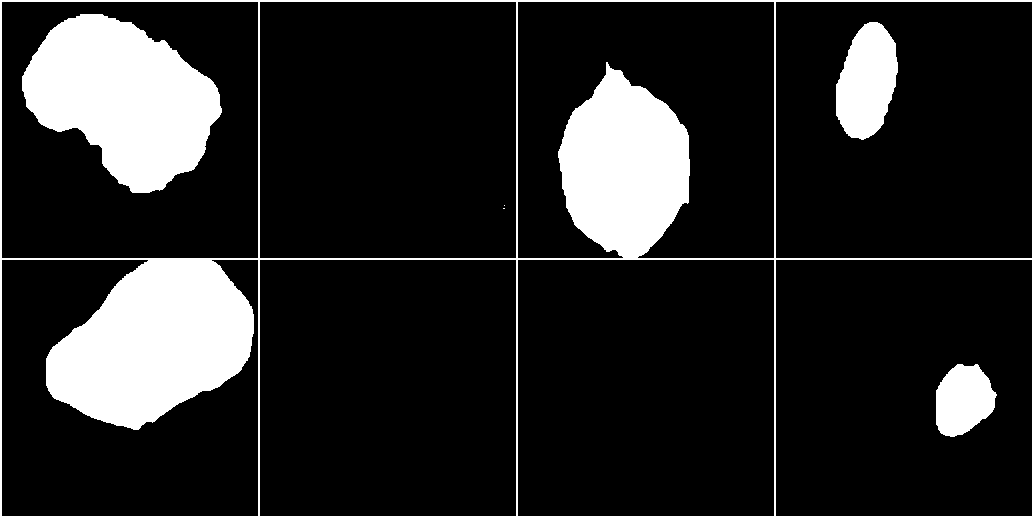

In [25]:
view_images(polyp_dir, 8, "*mask*")

Depending on how your generation went, you could have mostly black images. These would be healthy images, where there was no problem. If so, you can re-run the generation to see what polyps and masks look like.

### Loading the Images

We can now generate medical images. These could have lots of uses. We could use them to test a system, or as examples for people to look at. One of their most common applications is data augmentation. When we don't have enough data to train a model, we need to get more. If we can't get more real data, we can use these models to get data that "looks like" real data. In practice, we'd usually use this artificial data to pre-train a model, then use real data to "fine tune" the model.


To enable us to do this, Medigan has provided us with `get_as_torch_dataloader`. This generates images and sets up a `DataLoader` for us, all in one step. We need to tell it which model to use (`model_id`), how many images to make in total (`num_samples`), how many in each batch (`batch_size`), and if we want to shuffle. As usual, we'll want to shuffle in training but not in validation. We'll also need to set `prefetch_factor=None` to avoid an error message.

This makes a training set with $200$ images, with $4$ images in a batch. We'll keep using model `10`.

In [26]:
train_dataloader = generators.get_as_torch_dataloader(
    model_id=10, num_samples=200, batch_size=4, shuffle=True, prefetch_factor=None
)

We'll also need a validation data set.

**Task 5.3.9:** Make a data loader for validation data. This time we'll only have 30 images, and we won't shuffle. All other settings should be the same.

In [27]:
val_dataloader = generators.get_as_torch_dataloader(
    model_id=10, num_samples=30, batch_size=4, shuffle=False, prefetch_factor=None
)

test_batch = next(iter(val_dataloader))
test_batch_sample = test_batch["sample"]
print(f"Getting batches of shape {test_batch_sample.shape}")

Getting batches of shape torch.Size([4, 256, 256, 3])


<div class="alert alert-info" role="alert">
If you're wondering about that extra <tt>prefetch_factor</tt> argument, it has to do with multiple processing. Medigan is capable of creating several images simultaneously, which would speed up image generation at the cost of using more resources. If we turn that on by setting <tt>num_workers</tt> to a number greater than <tt>1</tt>, Medigan will create other small programs called workers that will run in the background and create images. These workers can "prefetch" images, meaning it generates them before they're needed, to further speed up the process. But we've chosen to not add this complexity, so we need to turn the prefetching off, since we don't have those extra workers to do it.
</div>

We saw before that this model generates both endoscope images and masks for them. Our data loader does the same, by giving us a dictionary with a `sample` key and a `mask` key. But this time each is a `torch` tensor rather than an image file. 

Let's look at an example of each. If your mask is all black for a healthy image, you can run the previous cell again to get a fresh batch.

Endoscope image shape: torch.Size([256, 256, 3])
Mask image shape: torch.Size([256, 256, 3])

Endoscope


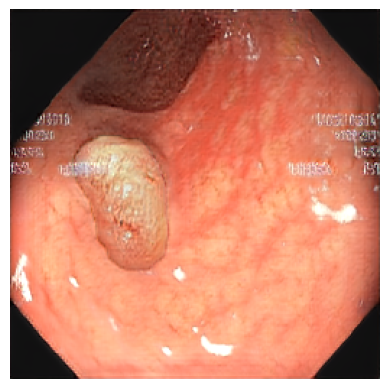

Mask


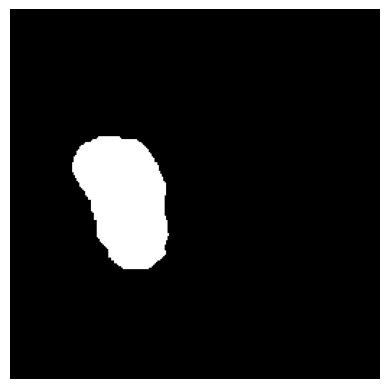

In [28]:
endoscope = test_batch["sample"]
mask = test_batch["mask"]
print(f"Endoscope image shape: {endoscope[0].shape}")
print(f"Mask image shape: {mask[0].shape}")
print()

print("Endoscope")
plt.imshow(endoscope[0])
plt.axis("off")
plt.show()

print("Mask")
plt.imshow(mask[0])
plt.axis("off")
plt.show()

Looking deeper, the mask data is only `0` or `1`. This will make it a good label for a classifier. We can check that with `unique` — it will tell us all the different values in our tensor.

**Task 5.3.10:** Call the `unique` method of the `mask` tensor to verify it only has `0` and `1`.

In [30]:
mask.unique()

tensor([0., 1.])

### Training a Model

We can use these data loaders to train a model. This model won't be a GAN, we already have one of those. Instead, we'll train a model that detects polyps on endoscope images. We'll use the images as the data, and the mask as the label. This should give us a model that takes in an image, and returns a mask highlighting any polyps. This would be quite useful to the medical industry, to speed up the processing of endoscope results and to double check in case the doctor may have missed something. Our GAN images aren't real data, but they're close enough to get a model doing the right low-level processing.

We could train a model from scratch, but as usual that isn't a good use of our time and resources. We'll do transfer learning, since there are many good pre-trained models that do this sort of detection of parts of an image. This process is called segmentation. A popular choice is `DeepLabV3`, so we'll use that. It's built into `torchvision`, we can load it in two lines.

In [31]:
pretrained_weights = (
    torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=pretrained_weights)

This is a very large convolutional network, ending in a classifier. Let's look at the model overall. Note the rather large classifier at the end, you can ignore the `aux_classifier` as we won't be using it.

In [32]:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Let's see what shape it gives us. We have a `test_batch_sample` from a few cells ago, we can run that through the model. You may have noticed the shape is a typical image shape of `[4, 256, 256, 3]`, but torch likes tensors of shape `[4, 3, 256, 256]` (so the channels before the height and width). Also, the model has two outputs: `out` and `aux`. We'll only use `out`.

In [33]:
test_batch_sample.shape

torch.Size([4, 256, 256, 3])

**Task 5.3.11:** Move the `test_batch_sample` to GPU, and get the shape of the `out` tensor. The code here takes care of adjusting the tensor to have channel in the second slot, running the model, and selecting the `out` output.

In [34]:
sample_cuda = test_batch_sample.to(device)

model.to(device)
moved_channel = sample_cuda.permute(0, 3, 1, 2)
result = model(moved_channel)
out = result["out"]

output_shape = out.shape
print(f"Output shape: {output_shape}")

Output shape: torch.Size([4, 21, 256, 256])


This is _almost_ what we need. We need it to match our mask, which only has one channel. The mask tensor actually has three, but they're all the same, so we'll only use the first one.

In [35]:
print(f"Shape from GAN: {test_batch['mask'].shape}")
print()
moved_channel_mask = test_batch["mask"][:, :, :, :1].permute(0, 3, 1, 2)
print(f"Shape we'll actually use: {moved_channel_mask.shape}")
print()

Shape from GAN: torch.Size([4, 256, 256, 3])

Shape we'll actually use: torch.Size([4, 1, 256, 256])



We'll need to do our usual process for transfer learning and modify the classifier part of the model. To minimize the training we'll need, we'll only replace the last layer. What is it currently?

In [36]:
model.classifier[-1]

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))

This is a convolutional layer that takes $256$ channels in and gives $21$ channels out. A convolutional layer with a $1$ x $1$ kernel doesn't change the height or width of the image, but does change the number of channels. Since we're already getting the right height and width, we should only change the number of out channels.

We'll want to replace this with another convolutional layer with the same kernel, but only one channel output.

**Task 5.3.12:** Create a convolutional layer that takes in `256` channels and outputs `1` channel, with a $1$ x $1$ kernel. Replace the classifier's final layer with it.

In [38]:
new_final_layer = torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))

model.classifier[-1] = new_final_layer

model.to(device)
print(f"New output shape: {model(moved_channel)['out'].shape}")

New output shape: torch.Size([4, 1, 256, 256])


That's what we wanted. Now we need to train. Unfortunately, we can't use the training code from previous projects, as we need to separate the `sample` and `mask`, and change the order from `[batch, height, width, channel]` to `[batch, channel, height, weight]`. Also, we can't really compute the "accuracy", since our target isn't a single value, but rather a whole image. We'll only have the loss. Here is a training function that has those modifications.

In [39]:
def train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs
):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for data_dict in tqdm(train_dataloader):
            inputs = data_dict.get("sample")
            masks = data_dict.get("mask")
            # Reorder dimensions to [batch_size, channels, height, width]
            inputs = inputs.permute(0, 3, 1, 2)
            masks = masks.permute(0, 3, 1, 2)
            # Reduce mask to single channel
            masks = masks[:, :1, :, :]

            inputs = inputs.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()

            # Select classifier output
            outputs = model(inputs)["out"]

            # Compute loss and step optimizer
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data_dict in tqdm(val_dataloader):
                inputs = data_dict.get("sample")
                masks = data_dict.get("mask")
                inputs = inputs.permute(0, 3, 1, 2)
                masks = masks.permute(0, 3, 1, 2)
                masks = masks[:, :1, :, :]

                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item() * inputs.size(0)

        val_epoch_loss = val_loss / len(val_dataloader.dataset)
        print(f"Validation Loss: {val_epoch_loss:.4f}")

Our function takes a few arguments: `model`, `train_dataloader`, `val_dataloader`, `criterion`, `optimizer`, `num_epochs`. We have the first three already, now we need the `criterion` and the `optimizer`, and we'll need to decide how many epochs to train.

The `criterion` is our loss function. We'll use the Binary Cross Entropy again. But this time we're getting the raw logit output, rather than values between $0$ and $1$. The right one to use here is `BCEWithLogitsLoss`.

We need to create an optimizer as well. We'll use `Adam` again, as it's often a good choice. After some experimenting, we found this model is a bit prone to overfitting, so we'll slow the training down.

**Task 5.3.13:** Fill in the code to create an `Adam` optimizer with the learning rate (`lr`) set to `0.0001`.

In [41]:
# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(
    f"Created optimizer of type {type(optimizer)} with learning rate {optimizer.defaults['lr']}"
)

Created optimizer of type <class 'torch.optim.adam.Adam'> with learning rate 0.0001


<div class="alert alert-info" role="alert">
    <p><b>Changes with respect to the video</b></p>
<p>The instructor in the video is training the model for 2 epochs before loading the fully trained model (in the next step).</p>
    <p>Given that training the models take a long time, we have since removed this step, you can safely proceed to the next section in which the model is loaded from <code>polyp_model.pth</code></p>
</div>

**Task 5.3.14:** Load the pre-trained model from `polyp_model.pth`

In [43]:
model_state = torch.load("polyp_model.pth")

# Load the state dictionary that has trained weights
model.load_state_dict(model_state)

<All keys matched successfully>

<div class="alert alert-info" role="alert">
You may have noticed that we didn't turn off training on the weights of the pre-trained model. This was intentional, as we found that if we did that the model performed quite poorly. In this situation, we needed to not just change the classification, but also tune the larger model. This is not uncommon. It often happens when what we want to do is a bit outside of what the model did originally, or when our data is sufficiently different from what the original model was trained on. In this case, it's more the latter. The model we're using was trained on a variety of full color images of people, animals, vehicles, etc. So we're specializing it a fair bit. And we found, again through experimenting, that it didn't take <i>too</i> much longer to train this way.
</div>

### Testing our Model

Great, we have a trained model! But we should make sure it's doing what we want.

Let's generate some new images to test it out.

**Task 5.3.15:** Create another data loader for model `10`. Only create $20$ images this time, in batches of $4$, without shuffling.

In [45]:
test_dataloader = generators.get_as_torch_dataloader(
    model_id=10, num_samples=20, batch_size=4, shuffle=False, prefetch_factor=None
)

final_test_batch = next(iter(test_dataloader))
final_test_sample = final_test_batch["sample"]
final_test_mask = final_test_batch["mask"]

print(f"Test sample image shape: {final_test_sample.shape}")
print(f"Test mask image shape: {final_test_mask.shape}")

Test sample image shape: torch.Size([4, 256, 256, 3])
Test mask image shape: torch.Size([4, 256, 256, 3])


The previous cell pulled a batch from the loader. The data was separated into the images (`final_test_sample`) and the masks (`final_test_mask`). Now we need the output of the model to compare. We'll need to move the channels on the input, and select the `out` part of the output.

**Task 5.3.16:** Fill in the missing parts to run the model on our `final_test_sample`. You'll need to `permute` the channel to the right place, move it to `device`, run the model on it, and select the `out` part of the output.

In [46]:
# Permute the channel to the right place
final_moved_channels = final_test_sample.permute(0,3,1,2)

# Move to the device (GPU)
final_moved_channels_cuda = final_moved_channels.to(device)

# Run the model
final_model_result = model(final_moved_channels_cuda)

# Select the out part of the result
final_out = final_model_result['out']

# Move the channel back to the last position so we can display the image
final_classifier_out = final_out.permute(0, 2, 3, 1)

print(f"Final images shape {final_classifier_out.shape}")

Final images shape torch.Size([4, 256, 256, 1])


If everything went according to plan, we should now have a `[4, 256, 256, 1]` tensor. That's four images. But we're not quite getting images, as we're getting the raw logits. We want a classifier type output, with values between $0$ and $1$. We're getting something else.

In [47]:
print("Getting range:")
final_classifier_out.min().item(), final_classifier_out.max().item()

Getting range:


(-8.206563949584961, 10.35721206665039)

We can repair that by running the result through a sigmoid function, which will ensure every value is between $0$ and $1$.

In [48]:
final_classifier_image = torch.sigmoid(final_classifier_out)

We're ready for the final reveal!

Here's a function that will plot the images in a torch tensor, in rows of $4$.

In [49]:
def plot_images_from_tensor(tensor):
    grid = make_grid(tensor.permute(0, 3, 1, 2), nrow=4, pad_value=1.0)
    return torchvision.transforms.ToPILImage()(grid)

We can run this on our `final_test_sample` to see the input endoscope images.

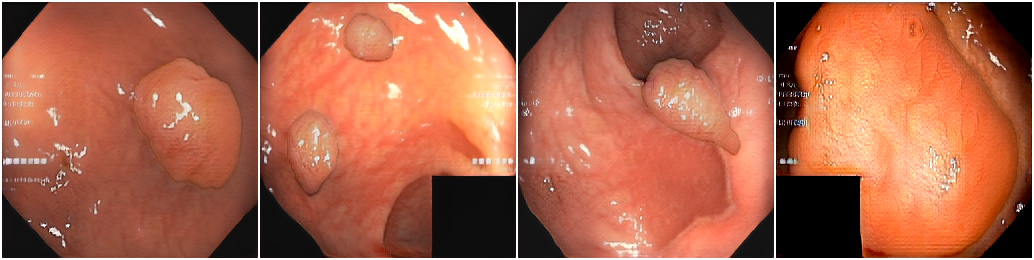

In [50]:
plot_images_from_tensor(final_test_sample)

This same function will work on our masks. We can compare the mask that we expect to be correct (`final_test_mask`) with our output (`final_classifier_image`) to see how our model performed.

**Task 5.3.17:** Run the `plot_images_from_tensor` on the `final_test_mask` and `final_classifier_image`. You'll need to do it in different cells.

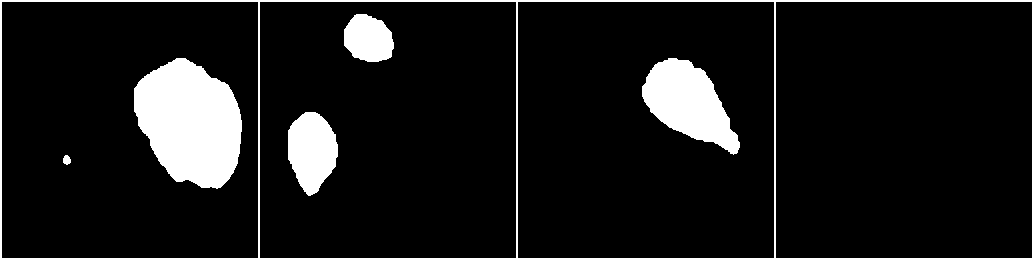

In [51]:
# Plot the final_test_mask — the "right answer"
plot_images_from_tensor(final_test_mask)

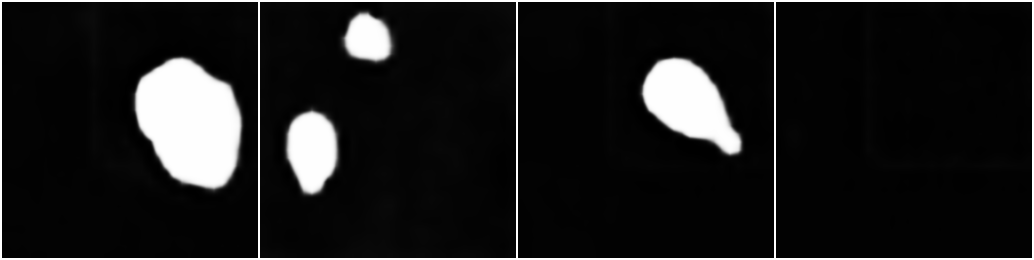

In [52]:
# Plot the final_classifier_image - what our model outputs
plot_images_from_tensor(final_classifier_image)

That did quite well, especially considering that it only took a few minutes to train! 

This wouldn't be the final model we'd apply to actual medical images. We'd need to fine tune it further on real data, that had been marked by an expert. But the model is in _extremely_ good shape and ready for that last bit of training, which should only take a few epochs to get the tuning right.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).